# 3 months prediction model

Target value counts
1    80412
0    77928
Name: next_three_months_pct_change_range, dtype: int64
Test set target value counts
0    4329
1    2343
Name: next_three_months_pct_change_range, dtype: int64
Overall Accuracy: 60.99%


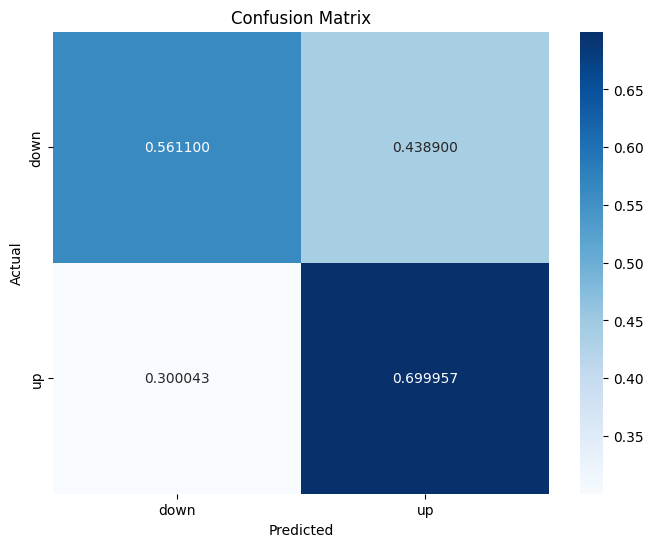

In [1]:

import datetime as dt
import sqlite3

from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.preprocessing import (
    OneHotEncoder,
)
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from analytics.machine_learning.price_prediction_with_fundamentals import utils
import pandas as pd

db_conn = sqlite3.connect('/Users/orestis/MyProjects/InvestorAPI/app/database/ibd.db')

query = '''
    SELECT * 
    FROM price_prediction_dataset_v2
    WHERE DATE(Date) <= date('now', '-3 months')
    ORDER BY DATE(Date)
'''

dataset = pd.read_sql(query, db_conn)
dataset.dropna(inplace=True)

# Create categorical target
bins = [-float('inf'), 0, float('inf')]
labels = ['down', 'up']
label_mapping = {0: 'down', 1: 'up'}

dataset['next_three_months_pct_change_range'] = pd.cut(
    dataset['price_pct_change_next_three_months'],
    bins=bins,
    labels=[0, 1],
    right=False
)

print("Target value counts")
print(dataset['next_three_months_pct_change_range'].value_counts())

train_set, test_set = utils.split_data_to_train_and_test(
    df=dataset,
    cutoff_date=dt.datetime(2023,8,1),
    cutoff_date_column_name='Date'
)

print("Test set target value counts")
print(test_set['next_three_months_pct_change_range'].value_counts())

cols_to_drop = ['symbol', 'Date', 'price_pct_change_next_six_months', 'price_pct_change_next_three_months', 'price_pct_change_next_month', 'next_three_months_pct_change_range']
target_col = 'next_three_months_pct_change_range'

y_train = train_set[target_col]
X_train = train_set.drop(cols_to_drop, axis=1)

y_test = test_set[target_col]
X_test = test_set.drop(cols_to_drop, axis=1)

# categorical_columns = ['sector', 'last_three_months_pct_change_range']
column_transformer = make_column_transformer(
    (
        OneHotEncoder(), ['sector']
    ),
    remainder='passthrough'
)

rf_classifier = make_pipeline(
    column_transformer,
    RandomForestClassifier()
)

rf_classifier.fit(X_train, y_train)
y_pred_rf_classifier = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_rf_classifier)
print(f"Overall Accuracy: {accuracy:.2%}")

y_test_labels = [label_mapping[y] for y in y_test]
y_pred_labels = [label_mapping[y] for y in y_pred_rf_classifier]
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels, labels=labels, normalize='true')

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Number of high probability predictions: 305
High prob predictions accuracy: 91.80%


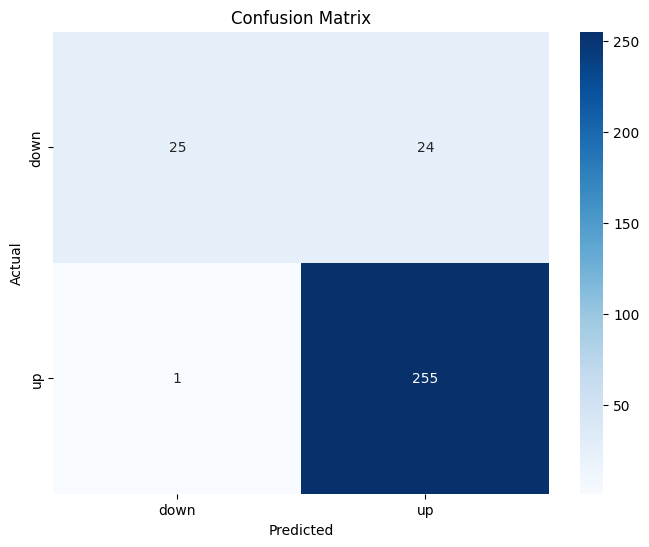

In [2]:
predicted_probabilities = rf_classifier.predict_proba(X_test)
y_pred_high_prob, y_test_high_prob = utils.get_high_prob_predictions_with_ground_truth_labels(
    predicted_probabilities=predicted_probabilities,
    y_pred=y_pred_rf_classifier,
    y_test=y_test,
    threshold=0.75
)

print("Number of high probability predictions:", len(y_pred_high_prob))
accuracy = accuracy_score(y_test_high_prob, y_pred_high_prob)
print(f"High prob predictions accuracy: {accuracy:.2%}")

y_test_labels = [label_mapping[y] for y in y_test_high_prob]
y_pred_labels = [label_mapping[y] for y in y_pred_high_prob]
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels, labels=labels)#, normalize='true')

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Store the model

In [3]:
import joblib

joblib.dump(rf_classifier, '/Users/orestis/MyProjects/InvestorAPI/analytics/machine_learning/price_prediction_with_fundamentals/ml_models/rf_three_months_prediction_model.joblib')

['/Users/orestis/MyProjects/InvestorAPI/analytics/machine_learning/price_prediction_with_fundamentals/ml_models/rf_three_months_prediction_model.joblib']

## Feature importance

In [3]:
# Extract feature names after one-hot encoding
ohe_feature_names = column_transformer.named_transformers_['onehotencoder'].get_feature_names_out(['sector'])

# Combine feature names with non-categorical column names
all_feature_names = list(ohe_feature_names) + list(X_train.columns.drop('sector'))

# Get feature importances from the trained RandomForestClassifier
feature_importances = rf_classifier.named_steps['randomforestclassifier'].feature_importances_

# Create a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the sorted feature importance
print(feature_importance_df)

                                              Feature  Importance
8                                      treasury_yield    0.050609
7                                       interest_rate    0.043890
12                   price_volatility_last_six_months    0.039246
15                  sector_pct_change_last_six_months    0.037121
13                 price_volatility_last_three_months    0.037071
9                    price_pct_change_last_six_months    0.034982
14                        price_volatility_last_month    0.034095
11                        price_pct_change_last_month    0.033983
10                 price_pct_change_last_three_months    0.033704
16                sector_pct_change_last_three_months    0.033574
17                       sector_pct_change_last_month    0.033289
34         property_plant_equipment_arctan_pct_change    0.028842
39                    total_revenue_arctan_pct_change    0.028236
40         total_shareholder_equity_arctan_pct_change    0.028225
29        

# 6 months predictions

Target value counts
1    76216
0    72127
Name: next_six_months_pct_change_range, dtype: int64
Test set target value counts
0    3478
1    3146
Name: next_six_months_pct_change_range, dtype: int64
Overall Accuracy: 69.16%


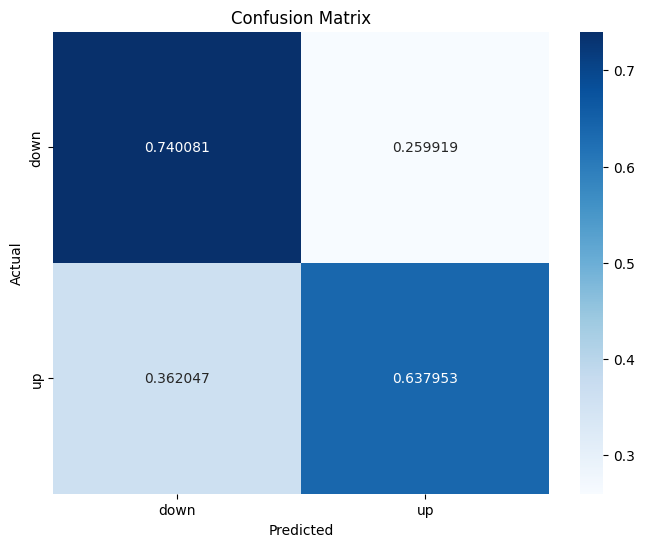

In [1]:

import datetime as dt
import sqlite3

from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.preprocessing import (
    OneHotEncoder,
)
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from analytics.machine_learning.price_prediction_with_fundamentals import utils
import pandas as pd

db_conn = sqlite3.connect('/Users/orestis/MyProjects/InvestorAPI/app/database/ibd.db')

query = '''
    SELECT * 
    FROM price_prediction_dataset_v2
    WHERE DATE(Date) <= date('now', '-6 months')
    ORDER BY DATE(Date)
'''

dataset = pd.read_sql(query, db_conn)
dataset.dropna(inplace=True)

# Create categorical target
bins = [-float('inf'), 0, float('inf')]
labels = ['down', 'up']
label_mapping = {0: 'down', 1: 'up'}

dataset['next_six_months_pct_change_range'] = pd.cut(
    dataset['price_pct_change_next_six_months'],
    bins=bins,
    labels=[0, 1],
    right=False
)

print("Target value counts")
print(dataset['next_six_months_pct_change_range'].value_counts())

train_set, test_set = utils.split_data_to_train_and_test(
    df=dataset,
    cutoff_date=dt.datetime(2023,5,1),
    cutoff_date_column_name='Date'
)

print("Test set target value counts")
print(test_set['next_six_months_pct_change_range'].value_counts())

cols_to_drop = ['symbol', 'Date', 'price_pct_change_next_six_months', 'price_pct_change_next_three_months', 'price_pct_change_next_month', 'next_six_months_pct_change_range']
target_col = 'next_six_months_pct_change_range'

y_train = train_set[target_col]
X_train = train_set.drop(cols_to_drop, axis=1)

y_test = test_set[target_col]
X_test = test_set.drop(cols_to_drop, axis=1)

# categorical_columns = ['sector', 'last_three_months_pct_change_range']
column_transformer = make_column_transformer(
    (
        OneHotEncoder(), ['sector']
    ),
    remainder='passthrough'
)

rf_classifier = make_pipeline(
    column_transformer,
    RandomForestClassifier()
)

rf_classifier.fit(X_train, y_train)
y_pred_rf_classifier = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_rf_classifier)
print(f"Overall Accuracy: {accuracy:.2%}")

y_test_labels = [label_mapping[y] for y in y_test]
y_pred_labels = [label_mapping[y] for y in y_pred_rf_classifier]
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels, labels=labels, normalize='true')

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Number of high probability predictions: 369
High prob predictions accuracy: 94.04%


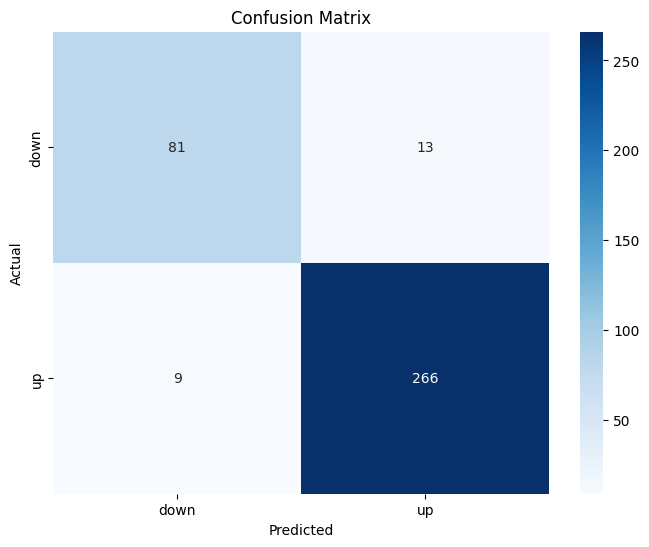

In [2]:
predicted_probabilities = rf_classifier.predict_proba(X_test)
y_pred_high_prob, y_test_high_prob = utils.get_high_prob_predictions_with_ground_truth_labels(
    predicted_probabilities=predicted_probabilities,
    y_pred=y_pred_rf_classifier,
    y_test=y_test,
    threshold=0.75
)

print("Number of high probability predictions:", len(y_pred_high_prob))
accuracy = accuracy_score(y_test_high_prob, y_pred_high_prob)
print(f"High prob predictions accuracy: {accuracy:.2%}")

y_test_labels = [label_mapping[y] for y in y_test_high_prob]
y_pred_labels = [label_mapping[y] for y in y_pred_high_prob]
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels, labels=labels)#, normalize='true')

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Store the model

In [3]:
import joblib

joblib.dump(rf_classifier, '/Users/orestis/MyProjects/InvestorAPI/analytics/machine_learning/price_prediction_with_fundamentals/ml_models/rf_six_months_prediction_model.joblib')

['/Users/orestis/MyProjects/InvestorAPI/analytics/machine_learning/price_prediction_with_fundamentals/ml_models/rf_six_months_prediction_model.joblib']

## Feature importance

In [5]:
# Extract feature names after one-hot encoding
ohe_feature_names = column_transformer.named_transformers_['onehotencoder'].get_feature_names_out(['sector'])

# Combine feature names with non-categorical column names
all_feature_names = list(ohe_feature_names) + list(X_train.columns.drop('sector'))

# Get feature importances from the trained RandomForestClassifier
feature_importances = rf_classifier.named_steps['randomforestclassifier'].feature_importances_

# Create a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the sorted feature importance
print(feature_importance_df)

                                              Feature  Importance
8                                      treasury_yield    0.079501
7                                       interest_rate    0.042854
12                   price_volatility_last_six_months    0.039671
15                  sector_pct_change_last_six_months    0.039180
13                 price_volatility_last_three_months    0.035091
14                        price_volatility_last_month    0.031908
9                    price_pct_change_last_six_months    0.031749
17                       sector_pct_change_last_month    0.031417
11                        price_pct_change_last_month    0.031106
16                sector_pct_change_last_three_months    0.030057
10                 price_pct_change_last_three_months    0.030031
34         property_plant_equipment_arctan_pct_change    0.029030
40         total_shareholder_equity_arctan_pct_change    0.027373
29              net_interest_income_arctan_pct_change    0.027371
39        